# Fine Tuning a CLIP model for the DermAI-Viz Use case:

Reference Notebook: https://huggingface.co/blog/herooooooooo/clip-finetune

In [1]:
%pip install -qq diffusers datasets accelerate wandb open-clip-torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
!git config --global credential.helper store

In [3]:
# Logging in to hugging face using tokens
from huggingface_hub import notebook_login

notebook_login()

In [4]:
import os
import datasets
from dataclasses import dataclass, field
from typing import Optional
import matplotlib.pyplot as plt
import requests
import random
import numpy as np
import torch
from datasets import load_dataset
from PIL import Image
from torchvision.io import ImageReadMode, read_image
from torchvision.transforms import CenterCrop, ConvertImageDtype, Normalize, Resize
from torchvision.transforms.functional import InterpolationMode
from pdb import set_trace

import transformers
from transformers import (
    VisionTextDualEncoderProcessor,
    VisionTextDualEncoderModel,
    AutoImageProcessor,
    AutoModel,
    AutoTokenizer,
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    set_seed,
)
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils import check_min_version, send_example_telemetry
from transformers.utils.versions import require_version

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='torchvision')

# Will error if the minimal version of Transformers is not installed. Remove at your own risks.
check_min_version("4.31.0.dev0")
require_version("datasets>=1.8.0", "To fix: pip install -r examples/pytorch/contrastive-image-text/requirements.txt")

2024-08-10 00:33:09.300731: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 00:33:09.300886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 00:33:09.431779: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Image Encoder for our CLIP is `clip-vit-base-patch32` and Text Encoder is `roberta-base`**

In [5]:
model = VisionTextDualEncoderModel.from_vision_text_pretrained(
    "openai/clip-vit-base-patch32", "roberta-base"
)

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
image_processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor = VisionTextDualEncoderProcessor(image_processor, tokenizer)

model.save_pretrained("clip-roberta")
processor.save_pretrained("clip-roberta")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The projection layer and logit scale weights `['visual_projection.weight', 'text_projection.weight', 'logit_scale']` are newly initialized. You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

[]

This part of the codebase is focused on creating and saving a dual encoder model that combines a vision model and a text model. Here’s a breakdown of what each line does:

1. **Loading the Vision-Text Dual Encoder Model:**
   ```python
   model = VisionTextDualEncoderModel.from_vision_text_pretrained(
       "openai/clip-vit-base-patch32", "roberta-base"
   )
   ```
   This line loads a pretrained model that combines a vision model (CLIP model from OpenAI) and a text model (RoBERTa). The `VisionTextDualEncoderModel` is designed to handle multimodal tasks, where both images and text are used as inputs. Here, it loads a CLIP model for the vision component and a RoBERTa model for the text component.

2. **Loading the Tokenizer:**
   ```python
   tokenizer = AutoTokenizer.from_pretrained("roberta-base")
   ```
   This line loads the tokenizer corresponding to the RoBERTa model. A tokenizer is responsible for converting text into a format (like tokens or IDs) that the model can understand.

3. **Loading the Image Processor:**
   ```python
   image_processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
   ```
   This line loads the image processor corresponding to the CLIP model. The image processor is responsible for preparing images (e.g., resizing, normalizing) in a way that the model can process them.

4. **Combining the Processors:**
   ```python
   processor = VisionTextDualEncoderProcessor(image_processor, tokenizer)
   ```
   This line creates a combined processor that can handle both images and text, using the previously loaded image processor and tokenizer. The `VisionTextDualEncoderProcessor` ensures that the inputs to the model are processed correctly.

5. **Saving the Model and Processor:**
   ```python
   model.save_pretrained("clip-roberta")
   processor.save_pretrained("clip-roberta")
   ```
   These lines save the model and the combined processor to the local directory "clip-roberta". This allows you to reload the same model and processor later without needing to download or configure them again.

**Summary:**
This code is preparing a multimodal model using CLIP for vision and RoBERTa for text, along with the necessary processors for handling images and text. It then saves the configured model and processor for future use.

In [6]:
@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune, or train from scratch.
    """

    model_name_or_path: str = field(
        metadata={"help": "Path to pretrained model or model identifier from huggingface.co/models"},
    )
    config_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    tokenizer_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    image_processor_name: str = field(default=None, metadata={"help": "Name or path of preprocessor config."})
    cache_dir: Optional[str] = field(
        default=None, metadata={"help": "Where do you want to store the pretrained models downloaded from s3"}
    )
    model_revision: str = field(
        default="main",
        metadata={"help": "The specific model version to use (can be a branch name, tag name or commit id)."},
    )
    use_fast_tokenizer: bool = field(
        default=True,
        metadata={"help": "Whether to use one of the fast tokenizer (backed by the tokenizers library) or not."},
    )
    use_auth_token: bool = field(
        default=False,
        metadata={
            "help": (
                "Will use the token generated when running `huggingface-cli login` (necessary to use this script "
                "with private models)."
            )
        },
    )


**We define two argument classes: ModelArguments and HfArgumentParser. This allows us to utilize Hugging Face’s HfArgumentParser in conjunction with the default TrainingArguments from Hugging Face.**

In [7]:
@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.
    """
    dataset_name: Optional[str] = field(
        default=None, metadata={"help": "The name of the dataset to use (via the datasets library)."}
    )
    data_dir: Optional[str] = field(default=None, metadata={"help": "The data directory containing input files."})
    image_column: Optional[str] = field(
        default="image_path",
        metadata={"help": "The name of the column in the datasets containing the full image file paths."},
    )
    caption_column: Optional[str] = field(
        default="caption",
        metadata={"help": "The name of the column in the datasets containing the image captions."},
    )
    max_seq_length: Optional[int] = field(
        default=128,
        metadata={
            "help": (
                "The maximum total input sequence length after tokenization. Sequences longer "
                "than this will be truncated, sequences shorter will be padded."
            )
        },
    )
    overwrite_cache: bool = field(
        default=False, metadata={"help": "Overwrite the cached training and evaluation sets"}
    )
    preprocessing_num_workers: Optional[int] = field(
        default=None,
        metadata={"help": "The number of processes to use for the preprocessing."},
    )


### Preparing the dataset

**First let's look at the available metadata for each image**

In [8]:
import pandas as pd

# Load the dataset from the 'inputs' directory
file_path = "/kaggle/input/skinimagescaptions/ddi_metadata.csv"

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()

Unnamed: 0  DDI_ID    DDI_file  skin_tone  malignant  \
0           0       1  000001.png         56       True   
1           1       2  000002.png         56       True   
2           2       3  000003.png         56       True   
3           3       4  000004.png         56       True   
4           4       5  000005.png         12       True   

                           disease  
0                 melanoma-in-situ  
1                 melanoma-in-situ  
2                mycosis-fungoides  
3  squamous-cell-carcinoma-in-situ  
4             basal-cell-carcinoma

In [10]:
# Get the distribution of values in the 'skin_tone' column
skin_tone_distribution = df['skin_tone'].value_counts()

# Display the distribution
print(skin_tone_distribution)

skin_tone
34    241
12    208
56    207
Name: count, dtype: int64


**Let's check what image looks like for the various above skin tones**

**Trying to print one image**

In [37]:
from PIL import Image
# import os
import os
    
def showImage(imageName:str):
    # Specify the directory and the image file name
    directory = "/kaggle/input/skinimages/ddidiversedermatologyimages"

    # Construct the full file path
    image_path = os.path.join(directory, imageName)

    # Load the image
    image = Image.open(image_path)
    
    return image

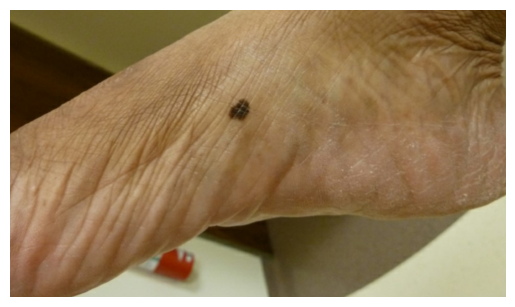

In [43]:
image_name = "000001.png"  # Replace with the specific image file you want to load
image = showImage(image_name)

# Display the image inline
plt.imshow(image)
plt.axis('off')  # Hide the axes
plt.show()

**Now that we have a function, let's try to pick images for different skin tones and see how they look like**

In [29]:
# Filter and sample 5 entries for each skin tone
sampled_12 = df[df['skin_tone'] == 12].sample(5, random_state=42)
sampled_34 = df[df['skin_tone'] == 34].sample(5, random_state=42)
sampled_56 = df[df['skin_tone'] == 56].sample(5, random_state=42)

# Combine the sampled data into a single DataFrame
sampled_df = pd.concat([sampled_12, sampled_34, sampled_56])

# Display the sampled entries
print(sampled_df)

     Unnamed: 0  DDI_ID    DDI_file  skin_tone  malignant  \
392         392     393  000393.png         12      False   
50           50      51  000051.png         12      False   
300         300     301  000301.png         12       True   
323         323     324  000324.png         12      False   
398         398     399  000399.png         12      False   
393         393     394  000394.png         34      False   
80           80      81  000081.png         34      False   
637         637     638  000638.png         34      False   
623         623     624  000624.png         34      False   
651         651     652  000652.png         34      False   
201         201     202  000202.png         56      False   
17           17      18  000018.png         56       True   
105         105     106  000106.png         56      False   
132         132     133  000133.png         56      False   
206         206     207  000207.png         56      False   

                       

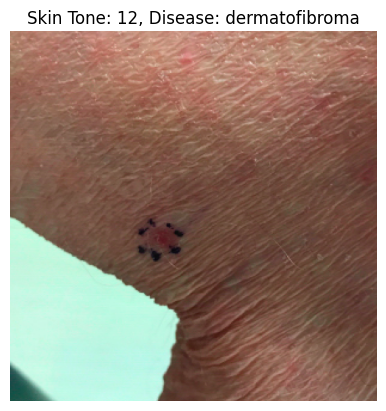

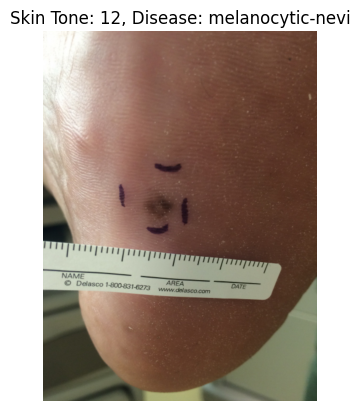

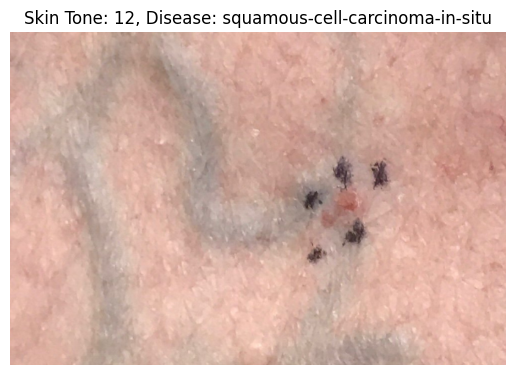

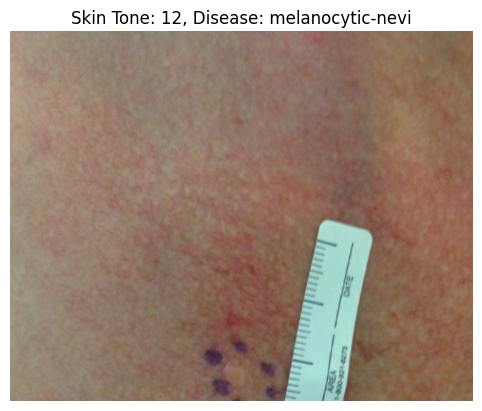

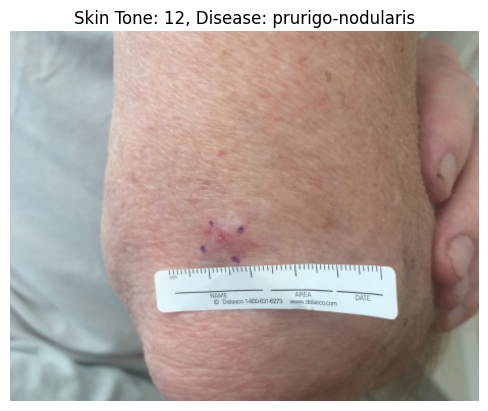

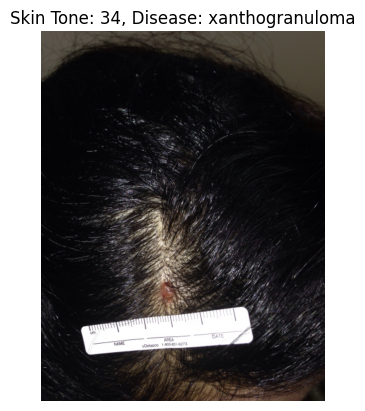

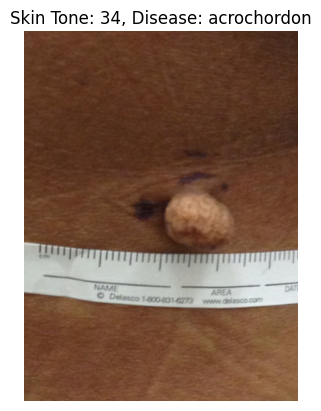

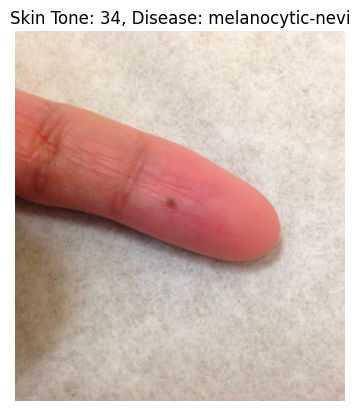

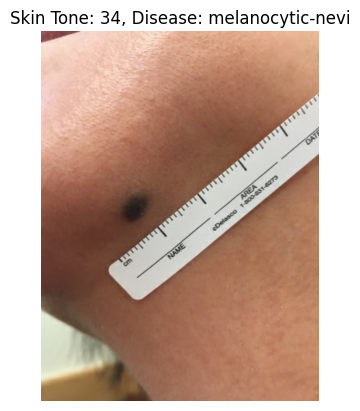

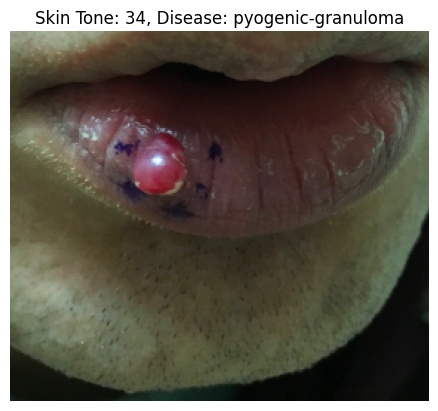

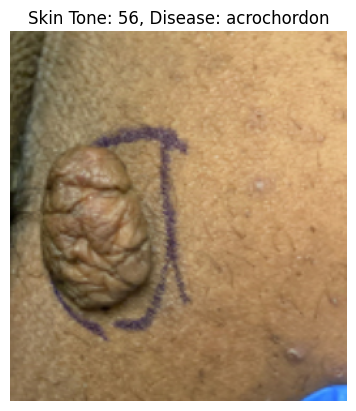

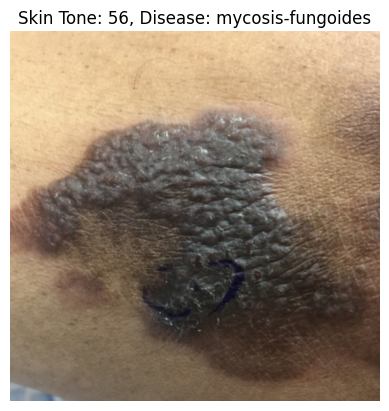

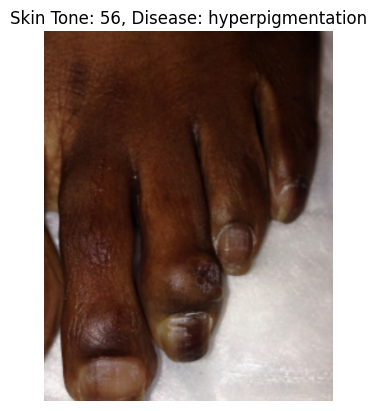

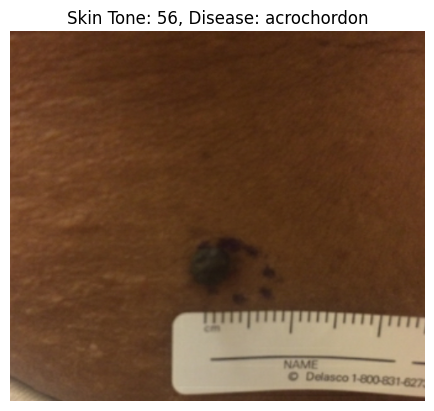

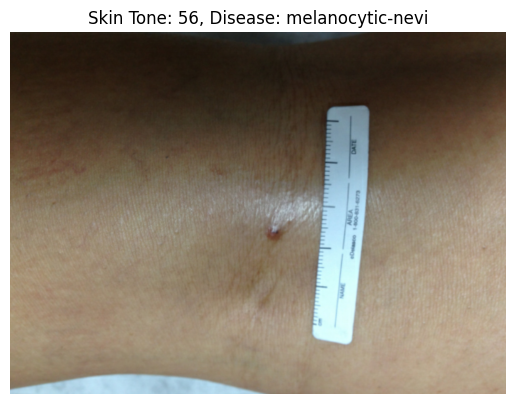

In [38]:
# Function to display images for the sampled data
def display_images(sampled_df):
    for index, row in sampled_df.iterrows():
        image_name = row['DDI_file']
        image = showImage(image_name)

        # Display the image inline
        plt.imshow(image)
        plt.title(f"Skin Tone: {row['skin_tone']}, Disease: {row['disease']}")
        plt.axis('off')  # Hide the axes
        plt.show()

# Call the function to display images
display_images(sampled_df)

### Looks like 12 is light, 34 is medium and 56 is dark tone

In [39]:
skin_tone_mapping = {
    12: "light",
    34: "medium",
    56: "dark",
}

In [40]:
# Function to generate captions based on metadata of the images 
def generate_caption(row):
    skin_tone_desc = skin_tone_mapping.get(row['skin_tone'], "unknown skin tone")
    malignant = "malignant" if row['malignant'] else "benign"
    disease = row['disease'].replace('-', ' ').capitalize()
    
    # Generate the caption
    caption = f"A {malignant} case of {disease} with {skin_tone_desc} skin tone."
    return caption

**Let's test it out**

In [41]:
df.iloc[0]

Unnamed: 0                   0
DDI_ID                       1
DDI_file            000001.png
skin_tone                   56
malignant                 True
disease       melanoma-in-situ
Name: 0, dtype: object

In [42]:
print(generate_caption(df.iloc[0]))

A malignant case of Melanoma in situ with dark skin tone.


We can go a step further here, by augmenting this caption with additional context generated with help of LLMs.
Let's go ahead and create the dataset that will be ready for fine tuning a clip model.

In [46]:
# Creating the column with full image path

image_directory = "/kaggle/input/skinimages/ddidiversedermatologyimages"

# Create a new column for the full image path
df['image_path'] = df['DDI_file'].apply(lambda x: os.path.join(image_directory, x))

In [47]:
# Generating the column with captions
# Create a new column for the caption
df['caption'] = df.apply(generate_caption, axis=1)

In [49]:
df.head()

Unnamed: 0  DDI_ID    DDI_file  skin_tone  malignant  \
0           0       1  000001.png         56       True   
1           1       2  000002.png         56       True   
2           2       3  000003.png         56       True   
3           3       4  000004.png         56       True   
4           4       5  000005.png         12       True   

                           disease  \
0                 melanoma-in-situ   
1                 melanoma-in-situ   
2                mycosis-fungoides   
3  squamous-cell-carcinoma-in-situ   
4             basal-cell-carcinoma   

                                          image_path  \
0  /kaggle/input/skinimages/ddidiversedermatology...   
1  /kaggle/input/skinimages/ddidiversedermatology...   
2  /kaggle/input/skinimages/ddidiversedermatology...   
3  /kaggle/input/skinimages/ddidiversedermatology...   
4  /kaggle/input/skinimages/ddidiversedermatology...   

                                             caption  
0  A malignant case of Melanoma in situ with dark...  
1  A malignant case of Melanoma in situ with dark...  
2  A malignant case of Mycosis fungoides with dar...  
3  A malignant case of Squamous cell carcinoma in...  
4  A malignant case of Basal cell carcinoma with ...

In [51]:
unique_diseases = df['disease'].unique()
unique_diseases

array(['melanoma-in-situ', 'mycosis-fungoides',
       'squamous-cell-carcinoma-in-situ', 'basal-cell-carcinoma',
       'squamous-cell-carcinoma', 'melanoma-acral-lentiginous',
       'basal-cell-carcinoma-superficial',
       'squamous-cell-carcinoma-keratoacanthoma',
       'subcutaneous-t-cell-lymphoma', 'melanocytic-nevi',
       'seborrheic-keratosis-irritated', 'focal-acral-hyperkeratosis',
       'hyperpigmentation', 'lipoma', 'foreign-body-granuloma',
       'blue-nevus', 'verruca-vulgaris', 'acrochordon', 'wart',
       'abrasions-ulcerations-and-physical-injuries',
       'basal-cell-carcinoma-nodular', 'epidermal-cyst',
       'acquired-digital-fibrokeratoma', 'epidermal-nevus',
       'seborrheic-keratosis', 'trichilemmoma', 'pyogenic-granuloma',
       'neurofibroma', 'syringocystadenoma-papilliferum',
       'nevus-lipomatosus-superficialis', 'benign-keratosis',
       'inverted-follicular-keratosis', 'onychomycosis', 'dermatofibroma',
       'trichofolliculoma', 'lympho

In [53]:
disease_common_name_mapping = {
  "melanoma-in-situ": "Early-stage melanoma",
  "mycosis-fungoides": "A type of cutaneous T-cell lymphoma",
  "squamous-cell-carcinoma-in-situ": "Bowen's disease",
  "basal-cell-carcinoma": "Basal cell cancer",
  "squamous-cell-carcinoma": "Squamous cell cancer",
  "melanoma-acral-lentiginous": "Acral lentiginous melanoma",
  "basal-cell-carcinoma-superficial": "Superficial basal cell cancer",
  "squamous-cell-carcinoma-keratoacanthoma": "Keratoacanthoma-type squamous cell carcinoma",
  "subcutaneous-t-cell-lymphoma": "Subcutaneous panniculitis-like T-cell lymphoma",
  "melanocytic-nevi": "Moles",
  "seborrheic-keratosis-irritated": "Irritated seborrheic keratosis",
  "focal-acral-hyperkeratosis": "Callus",
  "hyperpigmentation": "Darkening of the skin",
  "lipoma": "Fatty tumor",
  "foreign-body-granuloma": "Reaction to a foreign object in the skin",
  "blue-nevus": "Blue mole",
  "verruca-vulgaris": "Common wart",
  "acrochordon": "Skin tag",
  "wart": "Wart",
  "abrasions-ulcerations-and-physical-injuries": "Skin injuries",
  "basal-cell-carcinoma-nodular": "Nodular basal cell cancer",
  "epidermal-cyst": "Sebaceous cyst",
  "acquired-digital-fibrokeratoma": "A rare skin tumor on the finger or toe",
  "epidermal-nevus": "Noncancerous skin growth",
  "seborrheic-keratosis": "Noncancerous skin growth (common in aging)",
  "trichilemmoma": "A benign tumor of hair follicle origin",
  "pyogenic-granuloma": "Red bump on the skin, often after injury",
  "neurofibroma": "A nerve sheath tumor",
  "syringocystadenoma-papilliferum": "A rare sweat gland tumor",
  "nevus-lipomatosus-superficialis": "A rare type of mole",
  "benign-keratosis": "Noncancerous growth on the skin",
  "inverted-follicular-keratosis": "Noncancerous growth resembling a wart",
  "onychomycosis": "Fungal infection of the nail",
  "dermatofibroma": "Benign fibrous nodule",
  "trichofolliculoma": "Benign tumor of hair follicles",
  "lymphocytic-infiltrations": "Inflammatory condition of the skin",
  "prurigo-nodularis": "Itchy nodules on the skin",
  "kaposi-sarcoma": "Cancer associated with HHV-8",
  "scar": "Scar tissue",
  "eccrine-poroma": "Benign tumor of sweat glands",
  "angioleiomyoma": "Benign smooth muscle tumor",
  "keloid": "Overgrown scar tissue",
  "hematoma": "Localized collection of blood",
  "metastatic-carcinoma": "Cancer that has spread from another part of the body",
  "melanoma": "Skin cancer",
  "angioma": "Benign tumor of blood vessels",
  "folliculitis": "Inflammation of hair follicles",
  "atypical-spindle-cell-nevus-of-reed": "Rare type of mole",
  "xanthogranuloma": "Benign skin tumor in children",
  "eczema-spongiotic-dermatitis": "Eczema",
  "arteriovenous-hemangioma": "Benign vascular tumor",
  "acne-cystic": "Severe form of acne",
  "verruciform-xanthoma": "Rare benign tumor",
  "molluscum-contagiosum": "Viral skin infection",
  "condyloma-accuminatum": "Genital warts",
  "morphea": "Localized scleroderma",
  "neuroma": "Benign nerve tumor",
  "dysplastic-nevus": "Atypical mole",
  "nodular-melanoma-(nm)": "Aggressive form of melanoma",
  "actinic-keratosis": "Pre-cancerous skin lesion",
  "pigmented-spindle-cell-nevus-of-reed": "Rare pigmented mole",
  "dermatomyositis": "Inflammatory disease of the skin and muscles",
  "glomangioma": "Benign tumor of the glomus body",
  "cellular-neurothekeoma": "Benign skin tumor",
  "fibrous-papule": "Benign bump on the skin",
  "graft-vs-host-disease": "Complication of bone marrow transplant",
  "lichenoid-keratosis": "Benign skin lesion",
  "reactive-lymphoid-hyperplasia": "Benign proliferation of lymphoid tissue",
  "coccidioidomycosis": "Valley fever (fungal infection)",
  "leukemia-cutis": "Leukemia involving the skin",
  "sebaceous-carcinoma": "Malignant tumor of sebaceous glands",
  "chondroid-syringoma": "Benign sweat gland tumor",
  "tinea-pedis": "Athlete's foot",
  "solar-lentigo": "Age spots",
  "clear-cell-acanthoma": "Benign skin lesion",
  "abscess": "Collection of pus",
  "blastic-plasmacytoid-dendritic-cell-neoplasm": "Rare blood cancer",
  "acral-melanotic-macule": "Benign pigmented lesion"
}

In [54]:
# Function to generate captions based on metadata
def generate_caption(row):
    skin_tone_desc = skin_tone_mapping.get(row['skin_tone'], "unknown skin tone")
    malignant = "malignant" if row['malignant'] else "benign"
    disease = row['disease'].replace('-', ' ').capitalize()
    common_name = disease_common_name_mapping.get(row['disease'], "unknown disease")
    
    # Generate the caption with common name
    caption = f"A {malignant} case of {common_name} ({disease}) with {skin_tone_desc} skin tone."
    return caption

In [55]:
# Generating the column with captions
# Create a new column for the caption
df['caption'] = df.apply(generate_caption, axis=1)

In [61]:
for i in range(0,100, 5):
    print(df.iloc[i]['caption'])

A malignant case of Early-stage melanoma (Melanoma in situ) with dark skin tone.
A malignant case of Squamous cell cancer (Squamous cell carcinoma) with dark skin tone.
A malignant case of Squamous cell cancer (Squamous cell carcinoma) with dark skin tone.
A malignant case of A type of cutaneous T-cell lymphoma (Mycosis fungoides) with dark skin tone.
A malignant case of A type of cutaneous T-cell lymphoma (Mycosis fungoides) with dark skin tone.
A malignant case of A type of cutaneous T-cell lymphoma (Mycosis fungoides) with dark skin tone.
A malignant case of A type of cutaneous T-cell lymphoma (Mycosis fungoides) with dark skin tone.
A benign case of Moles (Melanocytic nevi) with medium skin tone.
A malignant case of Acral lentiginous melanoma (Melanoma acral lentiginous) with light skin tone.
A benign case of Moles (Melanocytic nevi) with light skin tone.
A benign case of Moles (Melanocytic nevi) with light skin tone.
A benign case of Fatty tumor (Lipoma) with dark skin tone.
A ben

**These comments look much more informative and easy to search for.**

In [62]:
df.head()

Unnamed: 0  DDI_ID    DDI_file  skin_tone  malignant  \
0           0       1  000001.png         56       True   
1           1       2  000002.png         56       True   
2           2       3  000003.png         56       True   
3           3       4  000004.png         56       True   
4           4       5  000005.png         12       True   

                           disease  \
0                 melanoma-in-situ   
1                 melanoma-in-situ   
2                mycosis-fungoides   
3  squamous-cell-carcinoma-in-situ   
4             basal-cell-carcinoma   

                                          image_path  \
0  /kaggle/input/skinimages/ddidiversedermatology...   
1  /kaggle/input/skinimages/ddidiversedermatology...   
2  /kaggle/input/skinimages/ddidiversedermatology...   
3  /kaggle/input/skinimages/ddidiversedermatology...   
4  /kaggle/input/skinimages/ddidiversedermatology...   

                                             caption  
0  A malignant case of Early-stage melanoma (Mela...  
1  A malignant case of Early-stage melanoma (Mela...  
2  A malignant case of A type of cutaneous T-cell...  
3  A malignant case of Bowen's disease (Squamous ...  
4  A malignant case of Basal cell cancer (Basal c...

In [72]:
df = df.drop(columns=["Unnamed: 0"])

In [205]:
from datasets import Dataset, DatasetDict

In [206]:
dataset = Dataset.from_pandas(df)

# Split the dataset into training and test sets
train_test_split = dataset.train_test_split(test_size=0.2)

# Further split the test set into validation and test sets
test_valid_split = train_test_split['test'].train_test_split(test_size=0.5)

# Combine the splits into a DatasetDict
final_datasets = DatasetDict({
    'train': train_test_split['train'],
    'validation': test_valid_split['train'],  # Use the train split from the previous split as validation
    'test': test_valid_split['test']          # Use the test split from the previous split as test
})


In [204]:
final_datasets

DatasetDict({
    train: Dataset({
        features: ['DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'image_path', 'caption'],
        num_rows: 524
    })
    validation: Dataset({
        features: ['DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'image_path', 'caption'],
        num_rows: 66
    })
    test: Dataset({
        features: ['DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'image_path', 'caption'],
        num_rows: 66
    })
})

### Continuing with setting up the trainer args for fine tuning

In [76]:
args_dict = {'output_dir': './clip-roberta-finetuned',
 'model_name_or_path': './clip-roberta',
 'data_dir': '/kaggle/input/skinimages/ddidiversedermatologyimages',
#  'dataset_name': 'arampacha/rsicd',
 'image_column': 'image_path', # Maps to the column name for full image path in the dataset
 'caption_column': 'caption', # Maps to the column for captions in the dataset
 'remove_unused_columns': False,
 'per_device_train_batch_size': 64,
 'per_device_eval_batch_size': 64,
 'learning_rate': 5e-05,
 'warmup_steps': 0,
 'weight_decay': 0.1,
 'overwrite_output_dir': True,
 'push_to_hub': False}

parser = HfArgumentParser((ModelArguments, DataTrainingArguments, TrainingArguments))
model_args, data_args, training_args = parser.parse_dict(args_dict)

In [ ]:
# Dataset
class Transform(torch.nn.Module):
    def __init__(self, image_size, mean, std):
        super().__init__()
        self.transforms = torch.nn.Sequential(
            Resize([image_size], interpolation=InterpolationMode.BICUBIC, antialias=True),
            CenterCrop(image_size),
            ConvertImageDtype(torch.float),
            Normalize(mean, std),
        )
    def forward(self, x) -> torch.Tensor:
        """`x` should be an instance of `PIL.Image.Image`"""
        with torch.no_grad():
            x = self.transforms(x)
        return x


This code defines a custom data transformation class in PyTorch called `Transform`. The purpose of this class is to preprocess images before they are passed into a neural network. Here’s a breakdown of what each part of the code does:

### Class Definition: `Transform`

```python
class Transform(torch.nn.Module):
```

- This defines a new class `Transform` that inherits from `torch.nn.Module`, which is the base class for all neural network modules in PyTorch. By inheriting from `torch.nn.Module`, this class can be used as part of a neural network pipeline.

### Initialization: `__init__`

```python
def __init__(self, image_size, mean, std):
    super().__init__()
    self.transforms = torch.nn.Sequential(
        Resize([image_size], interpolation=InterpolationMode.BICUBIC, antialias=True),
        CenterCrop(image_size),
        ConvertImageDtype(torch.float),
        Normalize(mean, std),
    )
```

- **Parameters:**
  - `image_size`: The desired size of the image after resizing and cropping.
  - `mean` and `std`: The mean and standard deviation used for normalizing the image.

- **`torch.nn.Sequential`:**
  - This is used to combine multiple transformations into a single pipeline that is applied sequentially to the input.

- **Transformations Applied:**
  1. **`Resize([image_size])`:** Resizes the image to the specified size using bicubic interpolation. The `InterpolationMode.BICUBIC` indicates that bicubic interpolation is used for resizing, which provides smoother results than bilinear or nearest-neighbor interpolation.
  
  2. **`CenterCrop(image_size)`:** Crops the image to the specified size from the center of the image.
  
  3. **`ConvertImageDtype(torch.float)`:** Converts the image data type to a floating-point tensor (torch.float).
  
  4. **`Normalize(mean, std)`:** Normalizes the image by subtracting the mean and dividing by the standard deviation for each channel. This is a common preprocessing step for images, especially when using pre-trained models.

### Forward Method: `forward`

```python
def forward(self, x) -> torch.Tensor:
    """`x` should be an instance of `PIL.Image.Image`"""
    with torch.no_grad():
        x = self.transforms(x)
    return x
```

- **`forward(self, x)`**: This method defines the forward pass of the transformation. When you pass an image through this `Transform` module, the `forward` method is called.

- **`with torch.no_grad()`:**
  - This context manager is used to disable gradient calculation. Since this transformation is purely for preprocessing and does not involve any learnable parameters, gradients do not need to be computed, which saves memory and computation.

- **Transformation Application:**
  - `x = self.transforms(x)`: The image `x`, which is expected to be an instance of `PIL.Image.Image`, is passed through the sequence of transformations defined in the `__init__` method.

- **Return:**
  - The method returns the transformed image as a tensor.

### Summary
The `Transform` class is designed to preprocess images in a consistent manner before feeding them into a model. It resizes, crops, converts the image to a floating-point tensor, and normalizes the image. This kind of preprocessing is essential for ensuring that the images fed into the model are in the correct format and scale for the model to process effectively.

In [172]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    input_ids = torch.tensor([example["input_ids"] for example in examples], dtype=torch.long)
    attention_mask = torch.tensor([example["attention_mask"] for example in examples], dtype=torch.long)
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "return_loss": True,
    }

The function `collate_fn` is designed to prepare and batch together a list of individual examples into a single batch that can be fed into a model during training or inference. This is a common practice when working with DataLoaders in PyTorch, which are responsible for loading data in batches.

### Breakdown of the `collate_fn` Function:

#### Function Signature:

```python
def collate_fn(examples):
```
- The function `collate_fn` takes a list of examples as its input. Each example is typically a dictionary containing various data elements (e.g., pixel values, input IDs, attention masks) that are associated with a single data point.

#### Stacking Pixel Values:

```python
pixel_values = torch.stack([example["pixel_values"] for example in examples])
```
- **Purpose:** This line extracts the `"pixel_values"` from each example and stacks them into a single tensor.
- **`torch.stack`:** The `torch.stack()` function concatenates a sequence of tensors (in this case, `example["pixel_values"]`) along a new dimension, effectively creating a batch of image tensors.
- **Result:** The `pixel_values` tensor will have a shape of `(batch_size, ...)`, where `batch_size` is the number of examples in the batch, and `...` represents the dimensions of each individual image tensor.

#### Converting `input_ids` to a Tensor:

```python
input_ids = torch.tensor([example["input_ids"] for example in examples], dtype=torch.long)
```
- **Purpose:** This line extracts the `"input_ids"` from each example, which are typically tokenized representations of text, and converts them into a single tensor.
- **`torch.tensor`:** The `torch.tensor()` function converts a list of input IDs into a tensor of the specified data type (`torch.long` in this case, which is often used for token IDs).
- **Result:** The `input_ids` tensor will have a shape of `(batch_size, sequence_length)`, where `sequence_length` is the length of the tokenized input.

#### Converting `attention_mask` to a Tensor:

```python
attention_mask = torch.tensor([example["attention_mask"] for example in examples], dtype=torch.long)
```
- **Purpose:** This line extracts the `"attention_mask"` from each example and converts it into a tensor.
- **`attention_mask`:** The attention mask is used in models like BERT to indicate which tokens should be attended to (usually 1 for real tokens and 0 for padding).
- **Result:** The `attention_mask` tensor will have the same shape as `input_ids`, i.e., `(batch_size, sequence_length)`.

#### Returning the Batch:

```python
return {
    "pixel_values": pixel_values,
    "input_ids": input_ids,
    "attention_mask": attention_mask,
    "return_loss": True,
}
```
- **Purpose:** The function returns a dictionary containing the batched `pixel_values`, `input_ids`, `attention_mask`, and a flag `return_loss` set to `True`.
- **Dictionary Structure:**
  - `"pixel_values"`: A batch of image tensors.
  - `"input_ids"`: A batch of token IDs.
  - `"attention_mask"`: A batch of attention masks.
  - `"return_loss"`: This is typically used by models during training to indicate that the loss should be computed and returned.

### Summary:
The `collate_fn` function is used to combine a list of individual examples into a single batch. It processes the `pixel_values`, `input_ids`, and `attention_mask` fields of each example, converting them into batched tensors that can be fed into a model. The function also includes a flag `return_loss` to indicate whether the model should calculate the loss during training. This function is often passed as the `collate_fn` argument in a PyTorch `DataLoader` to ensure that batches are created properly.

In [107]:
import matplotlib.pyplot as plt
from PIL import Image
import textwrap

def show_images(dset, num_images=8, with_caption=True, img_size=(4, 4)):
    num_columns = 1  # Set the number of columns to 1 for a single column layout
    num_rows = num_images  # Number of rows is equal to the number of images
    fig = plt.figure(figsize=(img_size[0] * num_columns, img_size[1] * num_rows))

    _list = list(range(len(dset)))
    for i in range(num_images):
        index = _list[i]
        ax = fig.add_subplot(num_rows, num_columns, i + 1)
        
        # Load the image from the path
        image_path = dset[index]['image_path']
        image = Image.open(image_path)
        
        # Display the image
        plt.imshow(image)
        
        # Set title as the first caption if required
        if with_caption:
            caption = dset[index]['caption']
            wrapped_caption = "\n".join(textwrap.wrap(caption, width=40))  # Adjust width as needed
            ax.set_title(wrapped_caption, fontsize=10, pad=10)
        
        # Remove axis
        ax.axis('off')
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    plt.show()


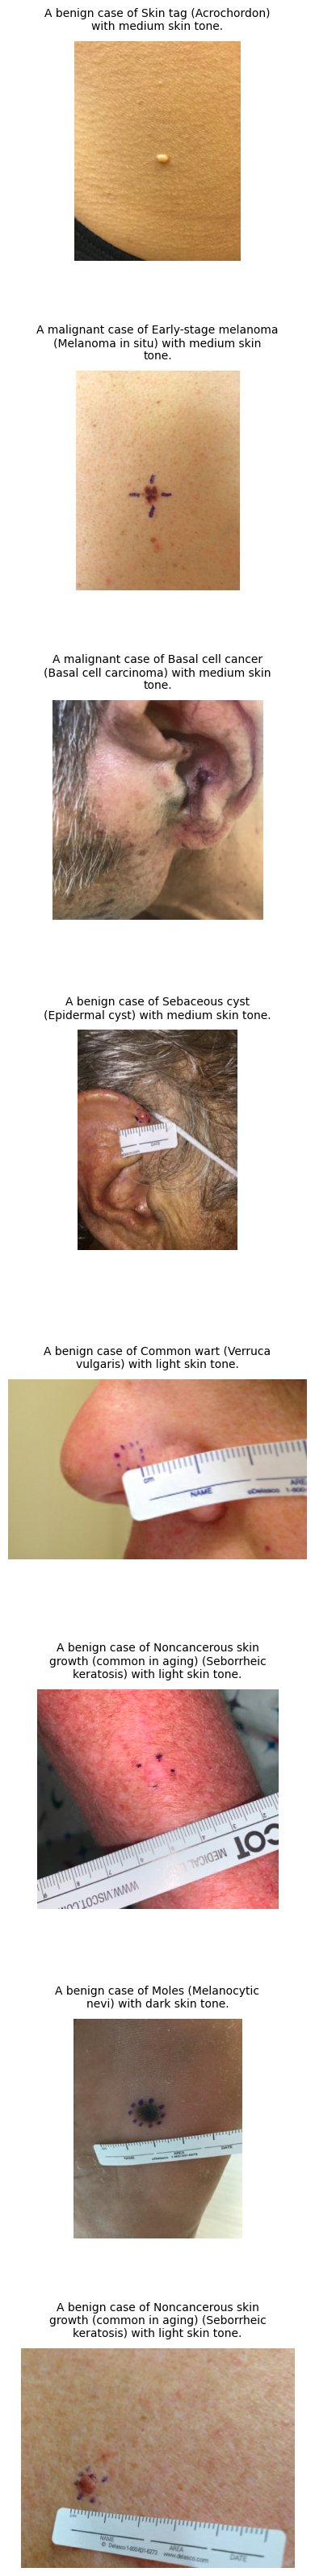

In [109]:
show_images(final_datasets['train'], num_images=8, with_caption=True)

In [110]:
tokenizer = AutoTokenizer.from_pretrained(
    model_args.model_name_or_path, cache_dir=model_args.cache_dir, use_fast=model_args.use_fast_tokenizer
)

In [111]:
image_processor = AutoImageProcessor.from_pretrained(
    model_args.image_processor_name or model_args.model_name_or_path,
    cache_dir=model_args.cache_dir,
    revision=model_args.model_revision,
    use_auth_token=True if model_args.use_auth_token else None,
)

model = AutoModel.from_pretrained(
    model_args.model_name_or_path,
    cache_dir=model_args.cache_dir,
    revision=model_args.model_revision,
    use_auth_token=True if model_args.use_auth_token else None,
)
config = model.config

In [112]:
set_seed(training_args.seed)

In [ ]:
image_transformations = Transform(
    config.vision_config.image_size, image_processor.image_mean, image_processor.image_std
)
image_transformations = torch.jit.script(image_transformations)

In [114]:
def tokenize_captions(examples):
    captions = [example[0] for example in examples[data_args.caption_column]]
    text_inputs = tokenizer(captions, max_length=data_args.max_seq_length, padding="max_length", truncation=True)
    examples["input_ids"] = text_inputs.input_ids
    examples["attention_mask"] = text_inputs.attention_mask
    return examples

def transform_images(examples):
    images = [torch.tensor(np.array(image)).permute(2, 0, 1) for image in examples[data_args.image_column]]
    examples["pixel_values"] = [image_transformations(image) for image in images]
    return examples

def filter_corrupt_images(examples):
    """remove problematic images"""
    valid_images = []
    for image_file in examples[data_args.image_column]:
        try:
            Image.open(image_file)
            valid_images.append(True)
        except Exception:
            valid_images.append(False)
    return valid_images

In [116]:
dataset = final_datasets

In [117]:
train_dataset = dataset["train"]
train_dataset = train_dataset.map(
    function=tokenize_captions,
    batched=True,
    num_proc=data_args.preprocessing_num_workers,
    load_from_cache_file=not data_args.overwrite_cache,
    desc="Running tokenizer on train dataset",
)
train_dataset.set_transform(transform_images)

Running tokenizer on train dataset:   0%|          | 0/524 [00:00<?, ? examples/s]

In [118]:
train_dataset

Dataset({
    features: ['DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'image_path', 'caption', 'input_ids', 'attention_mask'],
    num_rows: 524
})

In [120]:
eval_dataset = dataset["validation"]
eval_dataset = eval_dataset.map(
    function=tokenize_captions,
    batched=True,
    num_proc=data_args.preprocessing_num_workers,
    load_from_cache_file=not data_args.overwrite_cache,
    desc="Running tokenizer on validation dataset",
)
eval_dataset.set_transform(transform_images)

Running tokenizer on validation dataset:   0%|          | 0/66 [00:00<?, ? examples/s]

In [121]:
train_dataset, eval_dataset

(Dataset({
     features: ['DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'image_path', 'caption', 'input_ids', 'attention_mask'],
     num_rows: 524
 }),
 Dataset({
     features: ['DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'image_path', 'caption', 'input_ids', 'attention_mask'],
     num_rows: 66
 }))

In [122]:
processor =  VisionTextDualEncoderProcessor(image_processor, tokenizer)

Checking the base model prediction

In [126]:
# base model prediction
np.random.seed(0)
indices = np.random.choice(len(dataset['validation']), 8, replace=False)
patches = dataset['validation'].select(indices.tolist())

In [133]:
patches

Dataset({
    features: ['DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'image_path', 'caption'],
    num_rows: 8
})

In [130]:
indices

array([45, 28, 29, 55, 63, 31, 51, 46])

In [161]:
dataset['validation'][51]

{'DDI_ID': 651,
 'DDI_file': '000651.png',
 'skin_tone': 34,
 'malignant': False,
 'disease': 'blue-nevus',
 'image_path': '/kaggle/input/skinimages/ddidiversedermatologyimages/000651.png',
 'caption': 'A benign case of Blue mole (Blue nevus) with medium skin tone.'}

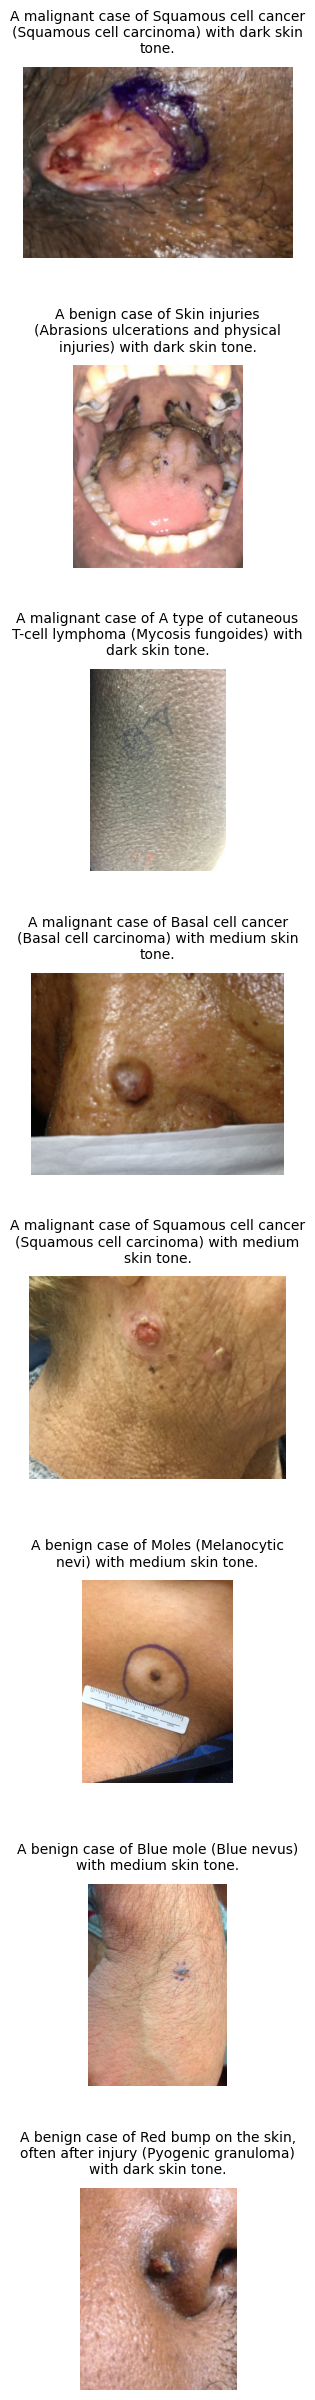

In [163]:
show_images(patches, 8, with_caption=True, img_size=(3, 3))

In [165]:
def show_result(model, patches, text, top_n=3):
    # Extract image paths and prepare captions
    image_paths = [patch['image_path'] for patch in patches]
    
    # Load images from paths
    images = [Image.open(patch['image_path']) for patch in patches]
    
    # Prepare inputs for the model using the loaded images
    inputs = processor(text=[text], images=images, return_tensors="pt", padding=True)
    inputs['input_ids'] = inputs['input_ids'].cuda()
    inputs['attention_mask'] = inputs['attention_mask'].cuda()
    inputs['pixel_values'] = inputs['pixel_values'].cuda()
    
    # Move model to GPU
    model = model.cuda()
    
    # Get model outputs
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    
    # Sort the outputs and get the top N indices
    sorted_idx = torch.sort(logits_per_image, dim=0, descending=True)[1][:, 0].tolist()
    sorted_idx = sorted_idx[:top_n]
    
    # Select the top N patches and prepare the dataset for show_images
    patches_sorted = [patches[i] for i in sorted_idx]
    dset = [{"image_path": patch['image_path'], "caption": f"Caption {patch['caption']}"} for i, patch in enumerate(patches_sorted)]
    
    # Display the top N images using your existing show_images function
    show_images(dset, num_images=len(dset), with_caption=True, img_size=(3, 3))


Unused or unrecognized kwargs: padding.


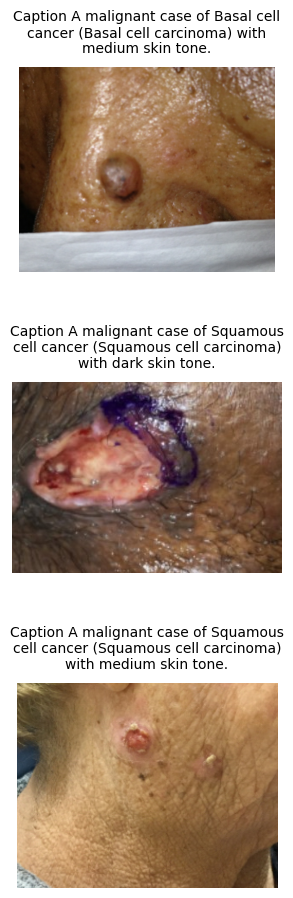

In [160]:
show_result(model, patches, 'Squamous cell cancer')

Unused or unrecognized kwargs: padding.


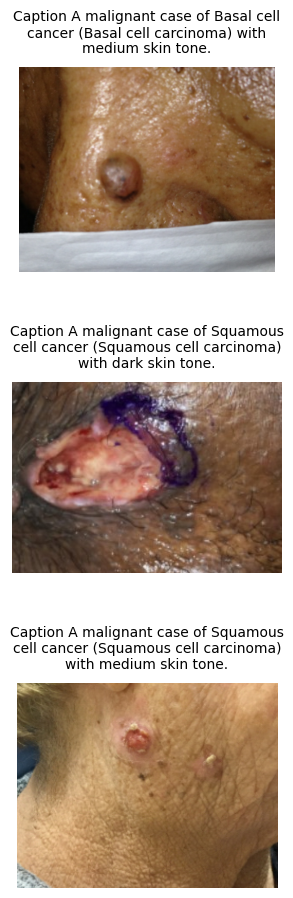

In [164]:
show_result(model, patches, 'A benign case of Blue mole (Blue nevus) with medium skin tone.')

Unused or unrecognized kwargs: padding.


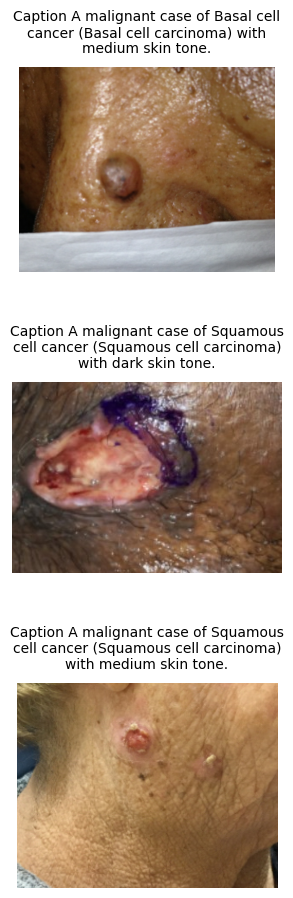

In [168]:
show_result(model, patches, 'dscdscbdvdhbdhbhdbashfdb')

The model is spewing out the same responses for any text input, let's try to fine tune it.

In [207]:
# Resetting the dataset
dataset = Dataset.from_pandas(df)

# Split the dataset into training and test sets
train_test_split = dataset.train_test_split(test_size=0.2)

# Further split the test set into validation and test sets
test_valid_split = train_test_split['test'].train_test_split(test_size=0.5)

# Combine the splits into a DatasetDict
final_datasets = DatasetDict({
    'train': train_test_split['train'],
    'validation': test_valid_split['train'],  # Use the train split from the previous split as validation
    'test': test_valid_split['test']          # Use the test split from the previous split as test
})
final_datasets

DatasetDict({
    train: Dataset({
        features: ['DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'image_path', 'caption'],
        num_rows: 524
    })
    validation: Dataset({
        features: ['DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'image_path', 'caption'],
        num_rows: 66
    })
    test: Dataset({
        features: ['DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'image_path', 'caption'],
        num_rows: 66
    })
})

In [208]:
final_datasets['train']

Dataset({
    features: ['DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'image_path', 'caption'],
    num_rows: 524
})

In [211]:
print(final_datasets['train'][0])

{'DDI_ID': 622, 'DDI_file': '000622.png', 'skin_tone': 34, 'malignant': False, 'disease': 'trichilemmoma', 'image_path': '/kaggle/input/skinimages/ddidiversedermatologyimages/000622.png', 'caption': 'A benign case of A benign tumor of hair follicle origin (Trichilemmoma) with medium skin tone.'}


In [219]:
def tokenize_text(examples):
    # Tokenize the captions
    tokenized = tokenizer(
        examples["caption"],
        padding="max_length",
        truncation=True,
        max_length=128  # Adjust max_length as needed
    )
    # Add the tokenized text to examples
    examples["input_ids"] = tokenized["input_ids"]
    examples["attention_mask"] = tokenized["attention_mask"]
    return examples

# Apply the tokenization function to the dataset
final_datasets = final_datasets.map(tokenize_text)

Map:   0%|          | 0/524 [00:00<?, ? examples/s]

Map:   0%|          | 0/66 [00:00<?, ? examples/s]

Map:   0%|          | 0/66 [00:00<?, ? examples/s]

In [212]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Define your image transformations here
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to a fixed size (optional)
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize (optional)
])

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Load image and convert to RGB
    image = image_transform(image)  # Apply transformations
    return image


In [226]:
def collate_fn(examples):
    pixel_values = torch.stack([load_image(example["image_path"]) for example in examples if "image_path" in example])
    
    if len(examples) > 0 and "input_ids" in examples[0]:
        input_ids = torch.tensor([example["input_ids"] for example in examples], dtype=torch.long)
    else:
        input_ids = torch.tensor([], dtype=torch.long)  # Ensure correct dtype
    
    if len(examples) > 0 and "attention_mask" in examples[0]:
        attention_mask = torch.tensor([example["attention_mask"] for example in examples], dtype=torch.long)
    else:
        attention_mask = torch.tensor([], dtype=torch.long)  # Ensure correct dtype

    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "return_loss": True,
    }


In [227]:
# 8. Initalize our trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_datasets['train'],
    eval_dataset=final_datasets['validation'],
    data_collator=collate_fn,
)

In [228]:
# # 9. Training
train_result = trainer.train()
trainer.log_metrics("train", train_result.metrics)
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)

***** train metrics *****
  epoch                    =        3.0
  total_flos               =   195474GF
  train_loss               =     3.9941
  train_runtime            = 0:01:04.41
  train_samples_per_second =     24.403
  train_steps_per_second   =      0.419


***** eval metrics *****
  epoch                   =        3.0
  eval_loss               =     4.0425
  eval_runtime            = 0:00:02.38
  eval_samples_per_second =     27.623
  eval_steps_per_second   =      0.837


The metrics provided show a snapshot of out model's training and evaluation performance at the end of training. Here’s a detailed breakdown of what these metrics mean and some considerations for interpreting them:

### Training Metrics
- **`epoch = 3.0`**: Indicates that the model has completed 3 epochs of training.
- **`total_flos = 195474GF`**: Represents the total number of floating-point operations performed during training. This gives an idea of the computational effort involved.
- **`train_loss = 3.9941`**: The average loss during training. Lower loss generally indicates better model performance. Compare this to the initial loss to evaluate if the model is learning effectively.
- **`train_runtime = 0:01:04.41`**: The total time taken for training. This indicates efficiency, though it needs to be interpreted relative to the complexity of the model and the size of the dataset.
- **`train_samples_per_second = 24.403`**: The number of training samples processed per second, which reflects the speed of training.
- **`train_steps_per_second = 0.419`**: The number of training steps processed per second.

### Evaluation Metrics
- **`epoch = 3.0`**: Indicates the evaluation is also done after 3 epochs.
- **`eval_loss = 4.0425`**: The loss computed on the evaluation (validation) set. This provides insight into how well the model generalizes to unseen data.
- **`eval_runtime = 0:00:02.38`**: The total time taken for evaluation.
- **`eval_samples_per_second = 27.623`**: The number of evaluation samples processed per second.
- **`eval_steps_per_second = 0.837`**: The number of evaluation steps processed per second.

### Considerations

1. **Training vs. Evaluation Loss**:
   - **Train Loss (3.9941)** vs. **Eval Loss (4.0425)**: Ideally, the evaluation loss should be close to or better than the training loss. In your case, the evaluation loss is slightly higher than the training loss, which is typical but should be monitored. Significant differences might indicate overfitting or issues with generalization.

2. **Runtime and Efficiency**:
   - **Training Runtime**: ~1 minute per epoch is quite fast, but ensure it aligns with the dataset size and model complexity.
   - **Evaluation Runtime**: ~2 seconds is also fast, which is good for quick validation.

3. **Samples and Steps per Second**:
   - **Training Samples per Second**: 24.403 is reasonable, but if you want faster training, consider optimizing hardware or model settings.
   - **Evaluation Samples per Second**: 27.623 is good for validation, indicating efficient evaluation performance.

4. **Further Evaluation**:
   - **Learning Curves**: Plot training and evaluation loss curves to check if the model is learning properly and not overfitting.
   - **Metrics Beyond Loss**: Evaluate other metrics such as accuracy, F1 score, or any relevant performance measures depending on your task.

### Summary
Overall, the metrics suggest that the model is training and evaluating reasonably well with fast runtimes and efficient processing. However, keep an eye on the slight discrepancy between training and evaluation loss to ensure the model generalizes well. Further analysis, such as plotting learning curves and assessing additional performance metrics, will provide a more comprehensive view of model performance.

To enhance your model's training and learning, you can adjust several settings and strategies. Here’s a comprehensive list of options to consider:

### 1. **Increase Training Duration**

- **Epochs**: Increase the number of epochs. Training for more epochs can help the model learn better, but be cautious of overfitting.
  
  ```python
  training_args.num_train_epochs = 5  # Increase from 3 to 5, for example
  ```

- **Steps Per Epoch**: If your dataset is large, you may need more steps per epoch to ensure the model gets enough exposure to the data.

  ```python
  training_args.max_steps = -1  # Remove maximum steps constraint or set to a higher number
  ```

### 2. **Adjust Learning Rate**

- **Learning Rate**: Modify the learning rate. Too high a learning rate can cause the model to converge too quickly to a suboptimal solution, while too low can slow down convergence.

  ```python
  training_args.learning_rate = 5e-5  # Adjust learning rate based on experimentation
  ```

- **Learning Rate Scheduler**: Use learning rate schedulers to adjust the learning rate dynamically during training.

  ```python
  from transformers import get_linear_schedule_with_warmup

  num_training_steps = len(train_dataloader) * training_args.num_train_epochs
  scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=0,
      num_training_steps=num_training_steps
  )
  ```

### 3. **Batch Size**

- **Increase Batch Size**: Larger batch sizes can lead to better gradient estimates but require more memory. Experiment with batch sizes to find the best trade-off between performance and resource usage.

  ```python
  training_args.per_device_train_batch_size = 16  # Increase from 8 to 16, for example
  ```

### 4. **Optimization and Regularization**

- **Optimizer**: Try different optimizers like AdamW or adjust optimizer parameters.

  ```python
  from transformers import AdamW
  optimizer = AdamW(model.parameters(), lr=training_args.learning_rate)
  ```

- **Weight Decay**: Add weight decay to prevent overfitting.

  ```python
  training_args.weight_decay = 0.01
  ```

- **Gradient Accumulation**: Use gradient accumulation to effectively increase batch size without requiring more memory.

  ```python
  training_args.gradient_accumulation_steps = 2
  ```

### 5. **Data Augmentation**

- **Augment Training Data**: Use data augmentation techniques to create more varied examples and prevent overfitting.

  ```python
  from torchvision import transforms

  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
      transforms.ToTensor(),
  ])
  ```

### 6. **Early Stopping and Checkpointing**

- **Early Stopping**: Implement early stopping to halt training if the model stops improving on the validation set.

  ```python
  from transformers import EarlyStoppingCallback
  trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))
  ```

- **Checkpointing**: Save model checkpoints regularly to avoid losing progress.

  ```python
  training_args.save_strategy = "epoch"  # Save model after each epoch
  ```

### 7. **Hyperparameter Tuning**

- **Hyperparameter Search**: Use techniques like grid search or random search to find the best hyperparameters for your model.

  ```python
  from transformers import Trainer, TrainingArguments
  from sklearn.model_selection import ParameterGrid

  param_grid = {
      'learning_rate': [5e-5, 3e-5, 1e-5],
      'per_device_train_batch_size': [8, 16],
      'num_train_epochs': [3, 5]
  }

  grid = ParameterGrid(param_grid)
  for params in grid:
      training_args = TrainingArguments(**params)
      trainer = Trainer(model=model, args=training_args, ...)
      trainer.train()
  ```

### 8. **Model Architecture**

- **Model Size**: Experiment with larger models if your resources allow. Larger models generally have more capacity to learn from data.

  ```python
  from transformers import RobertaForSequenceClassification
  model = RobertaForSequenceClassification.from_pretrained("roberta-large")
  ```

- **Fine-Tuning**: Fine-tune specific layers or use transfer learning to leverage pre-trained models.

### Summary

To improve training and learning:

1. **Increase Epochs**: Allow the model to train for more epochs.
2. **Adjust Learning Rate**: Tune the learning rate and use schedulers.
3. **Batch Size**: Increase batch size if memory allows.
4. **Optimize**: Use different optimizers and regularization methods.
5. **Data Augmentation**: Enhance data variability.
6. **Early Stopping**: Implement to prevent overfitting.
7. **Hyperparameter Tuning**: Search for optimal hyperparameters.
8. **Model Architecture**: Experiment with different models and sizes.

By adjusting these settings, you can improve your model's performance and ensure it learns better from the training data.

Unused or unrecognized kwargs: padding.


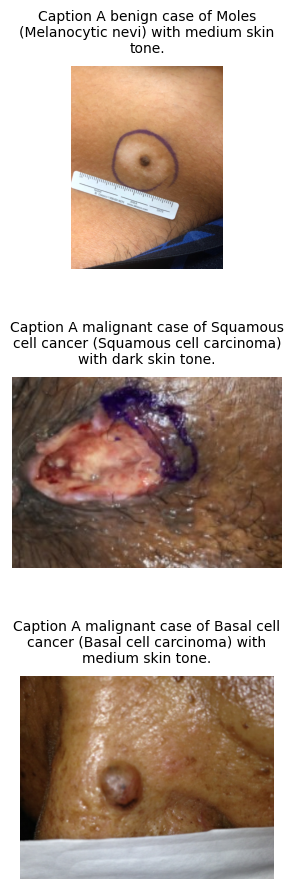

In [230]:
show_result(model, patches, 'A benign case of Blue mole (Blue nevus) with medium skin tone.')

Unused or unrecognized kwargs: padding.


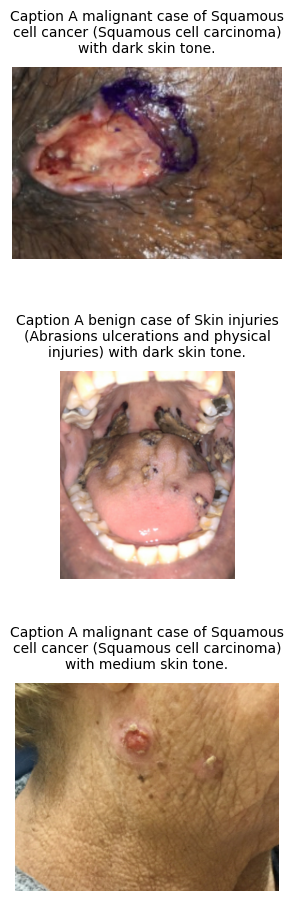

In [231]:
show_result(model, patches, 'Squamous cell cancer')

Looks like the model has learnt something, but can be done better.

In [232]:
training_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=no,
evaluation_strategy=None,
fp16=False,
fp16_backend=auto,
fp16

In [280]:
from transformers import TrainingArguments

# Let's update the training args 
updated_training_args = args_dict.copy()

# Adjusted for better memory management
updated_training_args['per_device_train_batch_size'] = 32

# Adjusted for better memory management
updated_training_args['per_device_eval_batch_size'] = 32

# Lowered learning rate for finer tuning
updated_training_args['learning_rate'] = 3e-5

# Added warmup steps to stabilize training
updated_training_args['warmup_steps'] = 1000  # Ensure stabilization at the start

# Lower weight decay for better regularization
updated_training_args['weight_decay'] = 0.01

# Increased number of epochs for extended training
updated_training_args['num_train_epochs'] = 1000

# More frequent logging to monitor training progress
updated_training_args['logging_strategy'] = 'epoch'  # Proportional to the number of epochs

updated_training_args['save_strategy'] = 'epoch'  # Proportional to the number of epochs

# Limit number of saved models to avoid excessive storage use
updated_training_args['save_total_limit'] = 3  # Increased to handle more checkpoints

# Evaluate model at specified intervals
updated_training_args['eval_strategy'] = 'epoch'

# Enable mixed precision training
updated_training_args['fp16'] = True

# Accumulate gradients over 4 steps to simulate larger batch size
updated_training_args['gradient_accumulation_steps'] = 4

# Use cosine scheduler for learning rate adjustment
updated_training_args['lr_scheduler_type'] = 'cosine'

# Increase number of workers for faster data loading
# updated_training_args['dataloader_num_workers'] = 4  # Increased for efficiency

# Directory for logging
updated_training_args['logging_dir'] = './clip-roberta-finetuned/logs'

# Track metrics using TensorBoard and Weights & Biases
updated_training_args['report_to'] = ['tensorboard', 'wandb']

# Enable early stopping
updated_training_args['load_best_model_at_end'] = True  # Load the best model at the end of training
updated_training_args['metric_for_best_model'] = 'eval_loss'  # Metric to monitor for early stopping
updated_training_args['greater_is_better'] = False  # Lower values of eval_loss are better

# Use an adaptive learning rate with the learning rate scheduler
updated_training_args['lr_scheduler_type'] = 'cosine_with_restarts'  # Adaptive learning rate

# Additional early stopping configuration (can be handled through a callback)
early_stopping_patience = 10  # Number of evaluation steps with no improvement to wait before stopping

In [281]:
model_args, data_args, training_args = parser.parse_dict(updated_training_args)

In [282]:
# Instantiate the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,    # Number of steps with no improvement before stopping
    early_stopping_threshold=0.0   # Minimum improvement to consider
)

# Include the callback in your trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_datasets['train'],
    eval_dataset=final_datasets['validation'],
    data_collator=collate_fn,
    callbacks=[early_stopping_callback]  # Add the early stopping callback here
)

In [284]:
# # 9. Training
train_result = trainer.train()
trainer.log_metrics("train", train_result.metrics)
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)

***** train metrics *****
  epoch                    =    10.8235
  total_flos               =   716739GF
  train_loss               =     1.9632
  train_runtime            = 0:04:38.42
  train_samples_per_second =   1882.021
  train_steps_per_second   =     14.367


***** eval metrics *****
  epoch                   =    10.8235
  eval_loss               =      4.189
  eval_runtime            = 0:00:01.80
  eval_samples_per_second =     36.612
  eval_steps_per_second   =      1.664
